In [1]:
from sklearn.model_selection import KFold
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde, spearmanr

from model import *

In [10]:
# Load cryptic seq data
seq_length = 46
file_path = 'data/train.csv'
decoy_path = 'data/decoys.csv'
X, y = read_data(file_path, decoy_path, decoy_mul=0)

# Mask the central dinucleotide from X
X = np.array([seq[:22] + 'NN' + seq[24:] for seq in X])

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results
fold_results = []
all_y_val = []
all_y_val_pred = []

# Perform 5-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"Fold {fold}")
    
    # Split data into train and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Initialize the model
    input_size = seq_length * 5  # 4 bases + N, one-hot encoded
    hidden_sizes = [230, 230]
    output_size = 1
    model = MLP(input_size, hidden_sizes, output_size)
    
    # Train the model
    train_model(model, X_train, y_train, batch_size=256, n_samples=5000, epochs=100, lr=5e-4, log=True)
    print(f"Fold {fold} training completed!")
    
    # Evaluate the model on validation set
    y_val_pred = np.array(eval_model(model, X_val))

    # Store y_val and y_val_pred
    all_y_val.extend(y_val)
    all_y_val_pred.extend(y_val_pred)
    
    # Calculate and store the mean squared error for this fold
    mse = np.mean((y_val - y_val_pred) ** 2)
    fold_results.append(mse)
    
    print(f"Fold {fold} MSE: {mse}")

# Convert lists to numpy arrays
all_y_val = np.array(all_y_val)
all_y_val_pred = np.array(all_y_val_pred)

# Print overall results
print("\nCross-validation results:")
for fold, mse in enumerate(fold_results, 1):
    print(f"Fold {fold} MSE: {mse}")
print(f"Average MSE: {np.mean(fold_results)}")
print(f"Standard deviation of MSE: {np.std(fold_results)}")

Fold 1
Training on device: mps
Epoch [10/100], Loss: 0.6212
Epoch [20/100], Loss: 0.8048
Epoch [30/100], Loss: 0.7295
Epoch [40/100], Loss: 0.9526
Epoch [50/100], Loss: 1.0473
Epoch [60/100], Loss: 0.5956
Epoch [70/100], Loss: 0.7346
Epoch [80/100], Loss: 0.6642
Epoch [90/100], Loss: 0.7031
Epoch [100/100], Loss: 0.9880
Fold 1 training completed!
Fold 1 MSE: 0.7349585666217312
Fold 2
Training on device: mps
Epoch [10/100], Loss: 2.4559
Epoch [20/100], Loss: 1.7380
Epoch [30/100], Loss: 0.5140
Epoch [40/100], Loss: 1.0496
Epoch [50/100], Loss: 0.6855
Epoch [60/100], Loss: 0.5165
Epoch [70/100], Loss: 0.6857
Epoch [80/100], Loss: 0.9204
Epoch [90/100], Loss: 0.8372
Epoch [100/100], Loss: 0.4693
Fold 2 training completed!
Fold 2 MSE: 0.7633894987494612
Fold 3
Training on device: mps
Epoch [10/100], Loss: 1.1219
Epoch [20/100], Loss: 0.7460
Epoch [30/100], Loss: 1.1909
Epoch [40/100], Loss: 0.9230
Epoch [50/100], Loss: 0.5622
Epoch [60/100], Loss: 0.7159
Epoch [70/100], Loss: 0.6984
Epoch 

Spearman correlation: 0.4205486271833145
P-value: 0.0


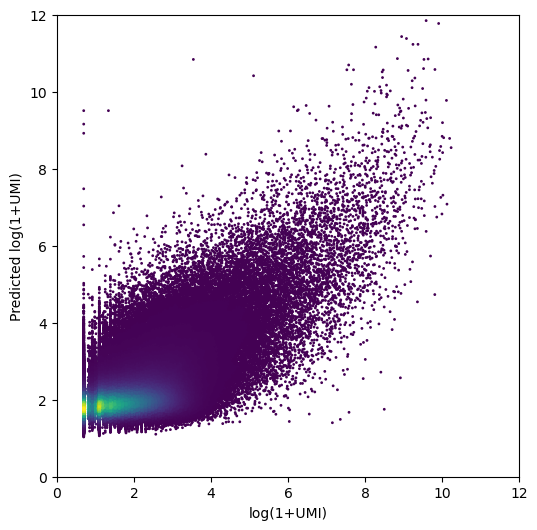

In [12]:
# Data
x = all_y_val
y = all_y_val_pred

# Calculate Spearman correlation
corr, p_value = spearmanr(x, y)

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(x,y,c=z,s=1)
#ax.scatter(x,y,s=1)

plt.xlabel('log(1+UMI)')
plt.ylabel('Predicted log(1+UMI)')
plt.xlim((0,12))
plt.ylim((0,12))
ax.set_aspect('equal')